In [3]:
import json
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
import torchvision.transforms as T
from transformers import BertTokenizer, BertModel, ViTModel, ViTImageProcessor 
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
import matplotlib.pyplot as plt

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu
from tqdm import tqdm
import numpy as np

# Dataset

In [4]:
def collate_fn(batch):
    images = torch.stack([item['image'] for item in batch])
    questions = [item['encoded_question'] for item in batch]
    raw_questions = [item['question'] for item in batch]
    raw_answers = [item['full_answer'] for item in batch]

    # Padding questions
    input_ids = [q['input_ids'] for q in questions]
    attention_mask = [q['attention_mask'] for q in questions]

    padded_input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    padded_attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)

    encoded_questions = {
        'input_ids': padded_input_ids,
        'attention_mask': padded_attention_mask
    }

    # Tokenize and pad answers
    encoded_answers = tokenizer(raw_answers, return_tensors='pt', padding=True, truncation=True, max_length=50)['input_ids']

    return {
        'image': images,
        'encoded_question': encoded_questions,
        'encoded_answer': encoded_answers,
        'question': raw_questions,
        'full_answer': raw_answers
    }

In [5]:
class GQADataset(Dataset):
    def __init__(self, questions_file, images_dir, tokenizer, transform=None):
        with open(questions_file, 'r') as f:
            self.questions = json.load(f)
        self.images_dir = images_dir
        self.transform = transform
        self.tokenizer = tokenizer

        self.questions_list = list(self.questions.items())

    def __len__(self):
        return len(self.questions_list)

    def __getitem__(self, idx):
        question_id, question_data = self.questions_list[idx]
        image_id = question_data['imageId']
        image_path = os.path.join(self.images_dir, image_id + '.jpg')
        
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file {image_path} not found")
        
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        question = question_data['question']
        full_answer = question_data.get('fullAnswer', 'unknown')
        
        encoded_question = self.tokenizer(question, return_tensors='pt', padding='max_length', truncation=True, max_length=50)
        
        sample = {
            'image': image,
            'encoded_question': {key: val.squeeze(0) for key, val in encoded_question.items()},
            'question': question,
            'full_answer': full_answer
        }
        
        return sample

In [19]:
# Define any required transformations
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])


# Define file paths
train_questions_file = '/kaggle/input/gqa-questions/train_balanced_questions.json'  # Update this path
val_questions_file = '/kaggle/input/gqa-questions/val_balanced_questions.json'  # Update this path
test_questions_file = '/kaggle/input/gqa-questions/test_balanced_questions.json'  # Update this path
images_dir = '/kaggle/input/gqa-images/images'  # Update this path

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Get vocabulary size
vocab_size = tokenizer.vocab_size
print(f'Vocabulary size: {vocab_size}')

# Create datasets for each split
train_dataset = GQADataset(questions_file=train_questions_file, 
                           images_dir=images_dir, 
                           tokenizer=tokenizer, 
                           transform=transform)

val_dataset = GQADataset(questions_file=val_questions_file, 
                         images_dir=images_dir, 
                         tokenizer=tokenizer, 
                         transform=transform)



BATCH_SIZE = 32
NUM_WORKER = 4

# Create DataLoaders for each split
train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=NUM_WORKER, 
                              collate_fn=collate_fn)

val_dataloader = DataLoader(val_dataset, 
                            batch_size=BATCH_SIZE, 
                            shuffle=True, 
                            num_workers=NUM_WORKER, 
                            collate_fn=collate_fn)

Vocabulary size: 30522


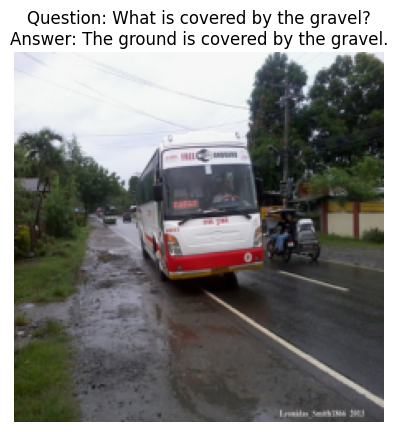

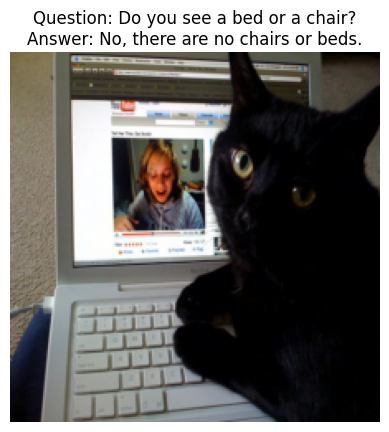

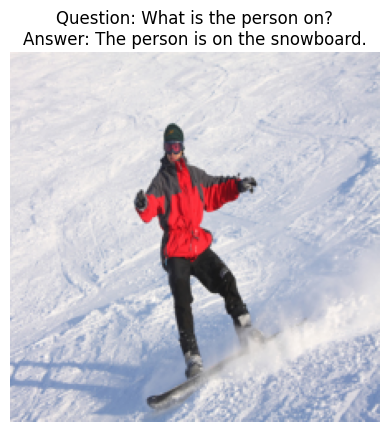

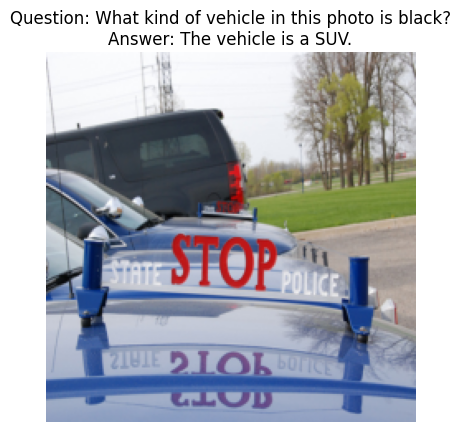

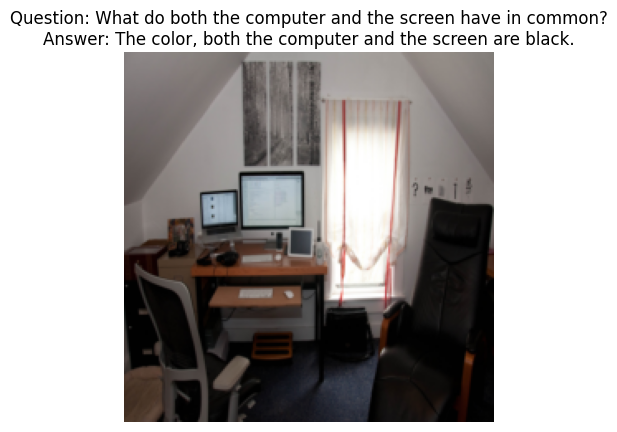

In [21]:
# Function to show images
def show_image(image, question, answer):
    plt.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.title(f"Question: {question}\nAnswer: {answer}")
    plt.axis('off')
    plt.show()

# Print some examples
for i, batch in enumerate(train_dataloader):
    if i >= 5:  # Show 5 examples
        break
    
    image = batch['image'][0]
    question = batch['question'][0]
    answer = batch['full_answer'][0]

    show_image(image, question, answer)

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, pretrained_model_name='google/vit-base-patch16-224', output_dim=768, freeze=True):
        super(ImageEncoder, self).__init__()
        self.feature_extractor = ViTImageProcessor.from_pretrained(pretrained_model_name, do_rescale=False)
        self.model = ViTModel.from_pretrained(pretrained_model_name)
        self.fc = nn.Linear(self.model.config.hidden_size, output_dim)
        
        if freeze:
            for name, param in self.model.named_parameters():
                if name not in ['pooler.dense.bias', 'pooler.dense.weight']:
                    param.requires_grad = False

    def forward(self, images):
        device = next(self.parameters()).device
        images = images.to(device)
        inputs = self.feature_extractor(images, return_tensors='pt').to(device)
        outputs = self.model(**inputs)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token representation
        encoded_images = self.fc(pooled_output)
        return encoded_images


class QuestionEncoder(nn.Module):
    def __init__(self, pretrained_model_name='bert-base-uncased', output_dim=768, freeze=True):
        super(QuestionEncoder, self).__init__()
        self.model = BertModel.from_pretrained(pretrained_model_name)
        self.fc = nn.Linear(self.model.config.hidden_size, output_dim)
        
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False

    def forward(self, questions):
        device = next(self.parameters()).device
        questions = {key: val.to(device) for key, val in questions.items()}
        outputs = self.model(**questions)
        last_hidden_state = outputs.last_hidden_state
        pooled_output = last_hidden_state[:, 0, :]
        encoded_questions = self.fc(pooled_output)
        return encoded_questions


In [ ]:
class VQADecoder(nn.Module):
    def __init__(self, hidden_dim, num_heads, num_layers, vocab_size):
        super(VQADecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=hidden_dim, nhead=num_heads), 
            num_layers=num_layers
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, tgt, memory):
        tgt = self.embedding(tgt)  # Ensure tgt is embedded to the correct dimension
        tgt_mask = self.generate_square_subsequent_mask(tgt.size(0)).to(tgt.device)
        transformer_output = self.transformer_decoder(tgt, memory, tgt_mask=tgt_mask)
        output = self.fc(transformer_output)
        return output

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [ ]:
class VQAModel(nn.Module):
    def __init__(self, image_encoder, question_encoder, vqa_decoder, hidden_dim, sos_token, eos_token):
        super(VQAModel, self).__init__()
        self.image_encoder = image_encoder
        self.question_encoder = question_encoder
        self.vqa_decoder = vqa_decoder
        self.hidden_dim = hidden_dim
        self.sos_token = sos_token
        self.eos_token = eos_token

    def forward(self, images, questions, answers=None, max_len=20):
        image_features = self.image_encoder(images)
        question_features = self.question_encoder(questions)
        memory = torch.cat((image_features.unsqueeze(0), question_features.unsqueeze(0)), dim=0)
        
        batch_size = images.size(0)
        if answers is not None:
            # Prepare target sequence for teacher forcing
            tgt = answers.transpose(0, 1)[:-1, :]  # Remove last token for teacher forcing
            output = self.vqa_decoder(tgt, memory)
        else:
            # Inference
            tgt = torch.full((1, batch_size), self.sos_token, dtype=torch.long, device=memory.device)
            outputs = []
            for _ in range(max_len):
                output = self.vqa_decoder(tgt, memory)
                pred = output[-1, :, :].argmax(dim=1, keepdim=True)
                tgt = torch.cat((tgt, pred.transpose(0, 1)), dim=0)
                outputs.append(pred)
                if (pred == self.eos_token).all():
                    break
            output = torch.cat(outputs, dim=0)
        return output
    
    def beam_search_inference(self, images, questions, beam_size=3, max_len=20):
        image_features = self.image_encoder(images)
        question_features = self.question_encoder(questions)
        memory = torch.cat((image_features.unsqueeze(0), question_features.unsqueeze(0)), dim=0)
        
        batch_size = images.size(0)
        sequences = [[[self.sos_token], 1.0]]  # List of lists with sequences and their scores

        for _ in range(max_len):
            all_candidates = []
            for seq, score in sequences:
                tgt = torch.tensor(seq, dtype=torch.long, device=memory.device).unsqueeze(1)
                output = self.vqa_decoder(tgt, memory)
                output = F.log_softmax(output[-1, :, :], dim=-1)
                topk = output.topk(beam_size, dim=-1)
                
                for i in range(beam_size):
                    candidate = [seq + [topk.indices[0][i].item()], score * topk.values[0][i].item()]
                    all_candidates.append(candidate)
            
            ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
            sequences = ordered[:beam_size]
            
            # Check for EOS token
            if all(sequences[i][0][-1] == self.eos_token for i in range(len(sequences))):
                break
        
        # Extract sequences
        final_sequences = [seq[0] for seq in sequences]
        return final_sequences

# Utils

In [ ]:
def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.

    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))

In [ ]:
def display_predictions(predictions, num_examples=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_examples):
        image, prediction, question = predictions[i]
        image = image.permute(1, 2, 0).numpy()  # Convert tensor image to numpy array
        image = np.clip(image, 0, 1)  # Clip values to [0, 1] range for display
        
        plt.subplot(num_examples // 5 + 1, 5, i + 1)
        plt.imshow(image)
        plt.title(f"Question: {question}\nAnswer: {prediction}")
        plt.axis('off')
    plt.show()

# Config

In [ ]:
hidden_dim = 768
num_heads = 8
num_layers = 6
model_lr = 3e-4
vocab_size = tokenizer.vocab_size  # Use BERT tokenizer's vocab size
sos_token = tokenizer.cls_token_id  # Use BERT's [CLS] token as SOS
eos_token = tokenizer.sep_token_id  # Use BERT's [SEP] token as EOS
smoothie = SmoothingFunction().method4

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Instantiate the model components
image_encoder = ImageEncoder().to(device)
question_encoder = QuestionEncoder().to(device)

vqa_decoder = VQADecoder(hidden_dim, 
                         num_heads, 
                         num_layers, 
                         vocab_size).to(device)

# Instantiate the VQA model
model = VQAModel(image_encoder, 
                 question_encoder, 
                 vqa_decoder, 
                 hidden_dim, 
                 sos_token, 
                 eos_token)

criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id).to(device)  # Ignore padding token in loss computation
optimizer = optim.Adam(model.parameters(), lr=model_lr)
model = model.to(device)

In [ ]:
def train(model, dataloader, criterion, optimizer, device, vocab_size):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training", leave=False):
        images = batch['image'].to(device)
        encoded_questions = {key: val.to(device) for key, val in batch['encoded_question'].items()}
        encoded_answers = batch['encoded_answer'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images, encoded_questions, answers=encoded_answers)
        
        # Adjust dimensions to match for loss calculation
        outputs = outputs.view(-1, vocab_size)
        targets = encoded_answers[:,1:]

        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        total_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [ ]:
def validate(model, dataloader, tokenizer, device, criterion, vocab_size):
    model.eval()
    total_bleu_score = 0
    total_loss = 0
    predictions = []
    
    references = []
    hypotheses = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation", leave=False):
            images = batch['image'].to(device)
            questions = batch['question']
            encoded_questions = {key: val.to(device) for key, val in batch['encoded_question'].items()}
            encoded_answers = batch['encoded_answer'].to(device)

            # Forward pass
            outputs = model(images, encoded_questions, answers=encoded_answers)
            
            # Adjust dimensions to match for loss calculation
            targets = encoded_answers[:, 1:]
            outputs = outputs.view(-1, vocab_size)
            
            loss = criterion(outputs, targets.reshape(-1))
            total_loss += loss.item()
                
            # Reference (ground truth answers)
            for i in range(len(encoded_answers)):
                answer = encoded_answers[i].tolist()
                sep_token_index = answer.index(tokenizer.sep_token_id)
                answer = answer[1:sep_token_index]
#                 answer_label = tokenizer.decode(answer, skip_special_tokens=True).split()
                references.append(answer)
            
            # Hypotheses (predicted answers)
            outputs = outputs.view(-1, encoded_answers.size(1) - 1, vocab_size)  # Reshape to batch_size x seq_len x vocab_size
            pred_tokens = outputs.argmax(dim=-1)  # Get the token indices with the highest probabilities
            
            for pred in pred_tokens:
                hypothesis = []
                for token in pred:
                    if token.item() == tokenizer.sep_token_id:
                        break
                    if token.item() != tokenizer.pad_token_id:
                        hypothesis.append(token.item())
                        
#                 hypothesis = tokenizer.decode(hypothesis, skip_special_tokens=True).split()
                hypotheses.append(hypothesis)
            
            # Calculate BLEU score for each prediction
            assert len(references) == len(hypotheses)
            batch_bleu_score = 0
            for ref, hyp in zip(references, hypotheses):
                smoothie = SmoothingFunction().method4
                bleu_score = sentence_bleu([ref], hyp, smoothing_function = smoothie)
                batch_bleu_score += bleu_score
            
            total_bleu_score += batch_bleu_score / len(hypotheses)
            
            # Store the prediction for visualization later
            for img, hyp, ques in zip(images, hypotheses, questions):
                predictions.append((img.cpu(), tokenizer.decode(hyp, skip_special_tokens=True), ques))
    
    avg_bleu_score = total_bleu_score / len(dataloader)
    avg_loss = total_loss / len(dataloader)

    # Display some predictions with images
    display_predictions(predictions, num_examples=1)

    return avg_bleu_score, avg_loss

In [ ]:
best_bleu = 0
epochs_since_improvement = 0
num_epochs = 100
patience = 20
    
for epoch in range(num_epochs):
    if epochs_since_improvement == 20:
        break
    if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
        adjust_learning_rate(optimizer, 0.8)

    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss = train(model=model, 
                       dataloader=train_dataloader, 
                       criterion=criterion, 
                       optimizer=optimizer, 
                       device=device,
                       vocab_size=vocab_size)
    
    val_bleu, val_loss = validate(model=model, 
                                  dataloader=val_dataloader, 
                                  tokenizer=tokenizer, 
                                  device=device,
                                  criterion=criterion,
                                  vocab_size=vocab_size)

    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation BLEU: {val_bleu:.4f}")

    if val_bleu > best_bleu:
        best_bleu = val_bleu
        epochs_since_improvement = 0
        torch.save(model.state_dict(), 'best_vqa_model.pth')
    else:
        epochs_since_improvement += 1

    if epochs_since_improvement >= patience:
        print("Early stopping triggered.")
        break

Epoch 1


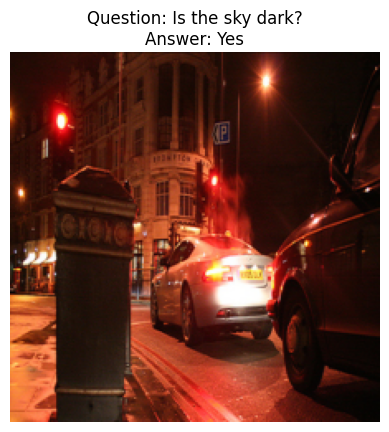

Train Loss: 1.7632, Validation Loss: 3.523, BLEU: 0.157
Epoch 2


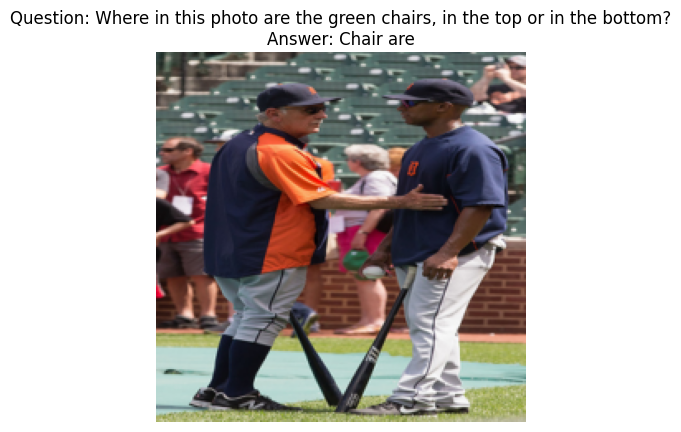

Train Loss: 5.4745, Validation Loss: 4.71, BLEU: 0.047
Epoch 3


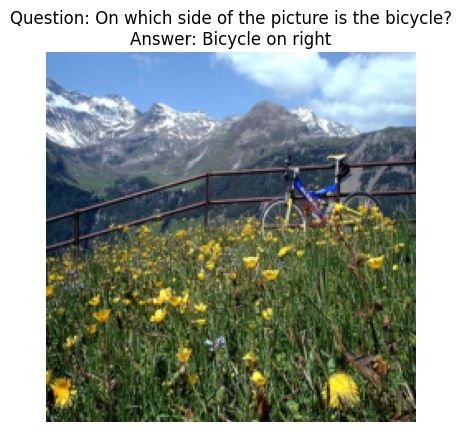

Train Loss: 4.7494, Validation Loss: 4.175, BLEU: 0.077
Epoch 4


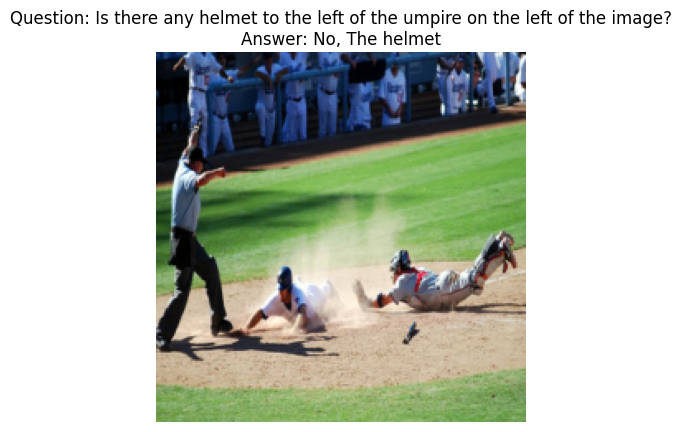

Train Loss: 4.1886, Validation Loss: 3.93, BLEU: 0.091
Epoch 5


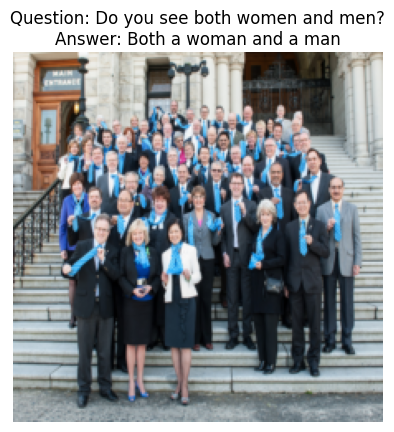

Train Loss: 3.8638, Validation Loss: 3.784, BLEU: 0.102
Epoch 6


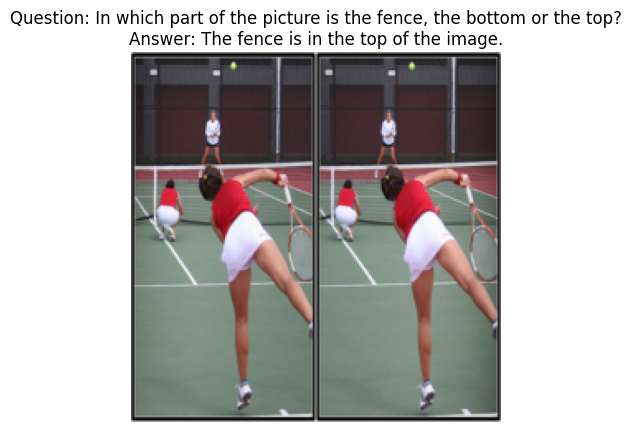

Train Loss: 3.8611, Validation Loss: 3.681, BLEU: 0.106
Epoch 7


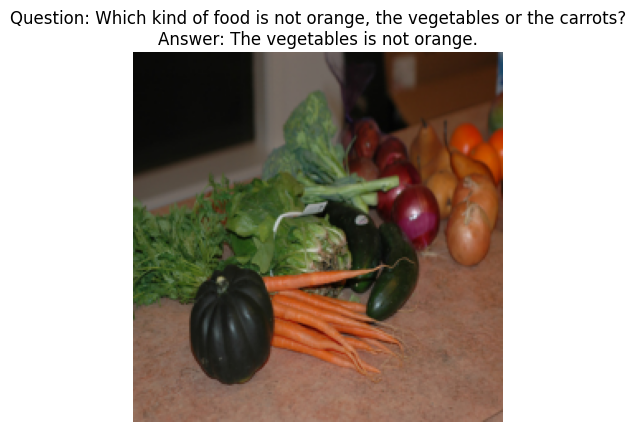

Train Loss: 3.5438, Validation Loss: 3.604, BLEU: 0.112
Epoch 8


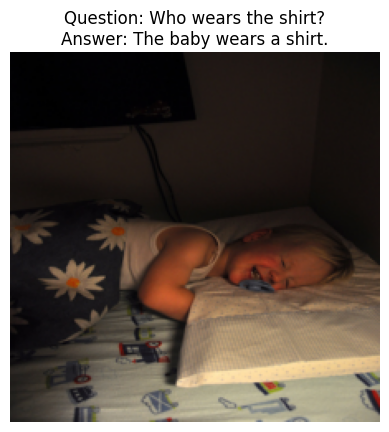

Train Loss: 3.3, Validation Loss: 3.553, BLEU: 0.117
Epoch 9


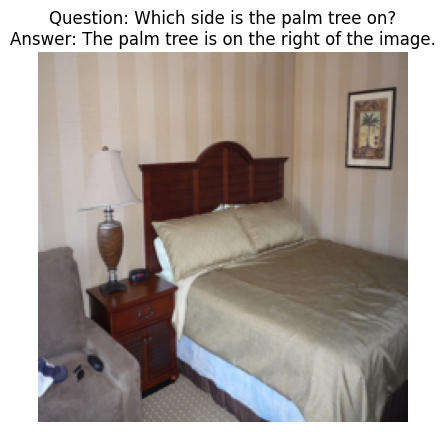

Train Loss: 3.0115, Validation Loss: 3.518, BLEU: 0.118
Epoch 10


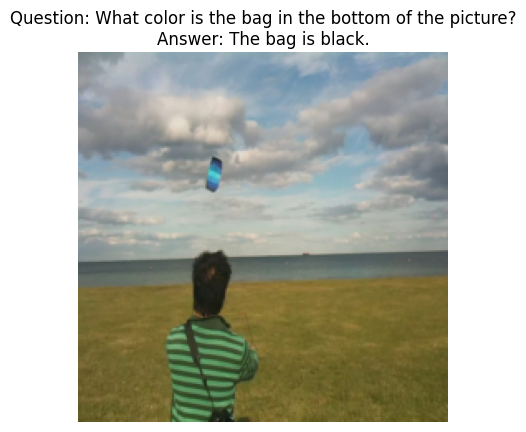

Train Loss: 2.715, Validation Loss: 3.488, BLEU: 0.122
Epoch 11


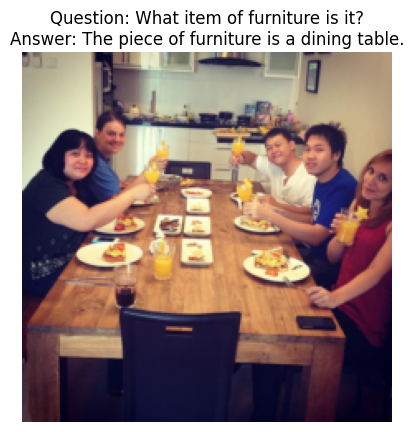

Train Loss: 2.5727, Validation Loss: 3.453, BLEU: 0.143
Epoch 12


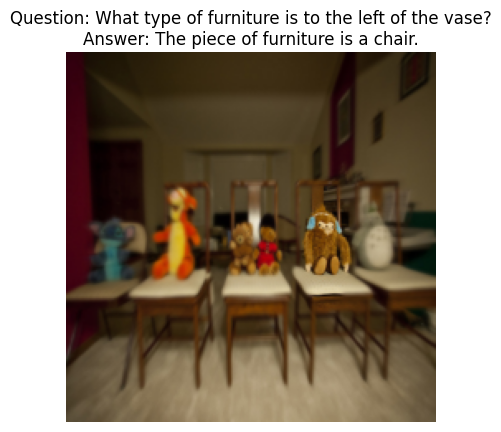

Train Loss: 2.2895, Validation Loss: 3.471, BLEU: 0.156
Epoch 13


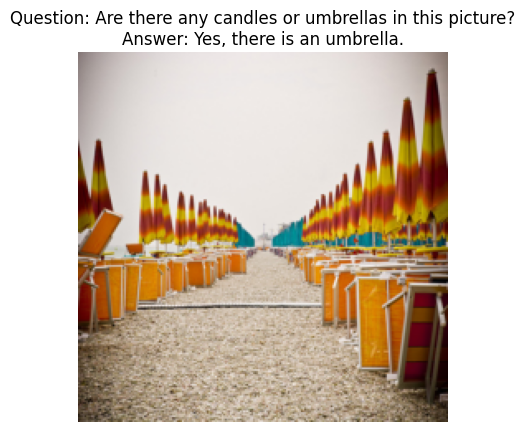

Train Loss: 2.2417, Validation Loss: 3.451, BLEU: 0.167
Epoch 14


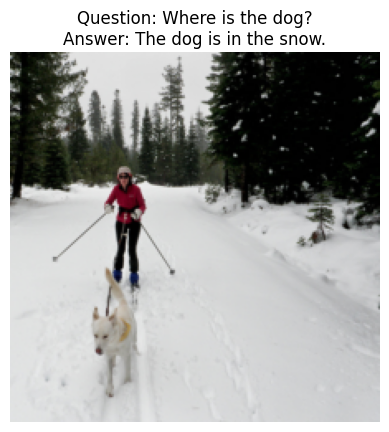

Train Loss: 2.0445, Validation Loss: 3.45, BLEU: 0.156
Epoch 15


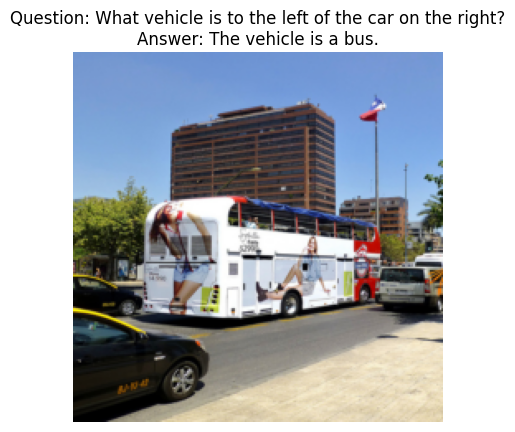

Train Loss: 1.9505, Validation Loss: 3.453, BLEU: 0.155
Epoch 16


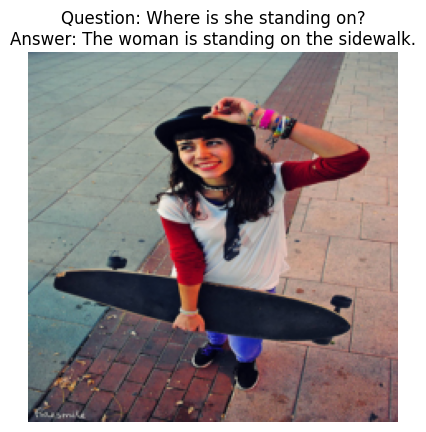

Train Loss: 1.9806, Validation Loss: 3.454, BLEU: 0.161
Epoch 17


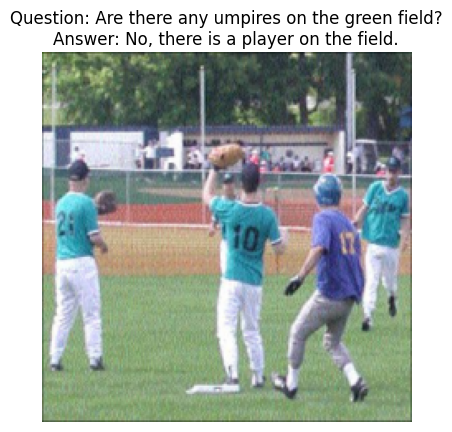

Train Loss: 1.821, Validation Loss: 3.472, BLEU: 0.153
Epoch 18


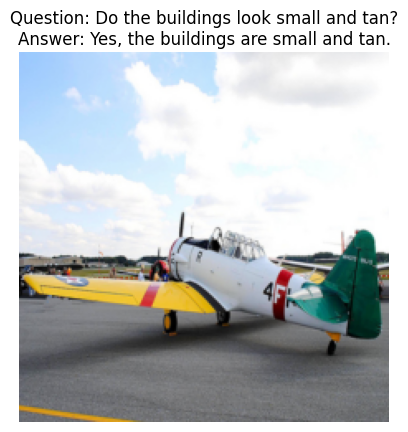

Train Loss: 1.7275, Validation Loss: 3.482, BLEU: 0.157
Epoch 19


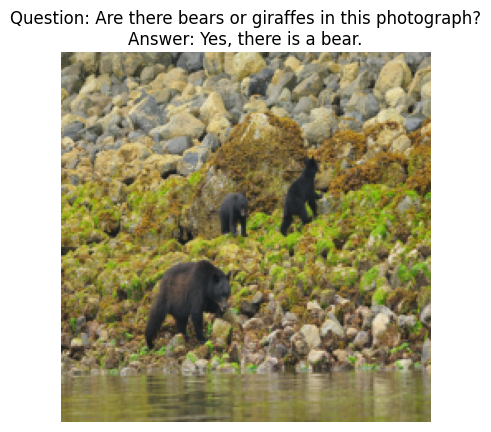

Train Loss: 1.6722, Validation Loss: 3.484, BLEU: 0.151
Epoch 20


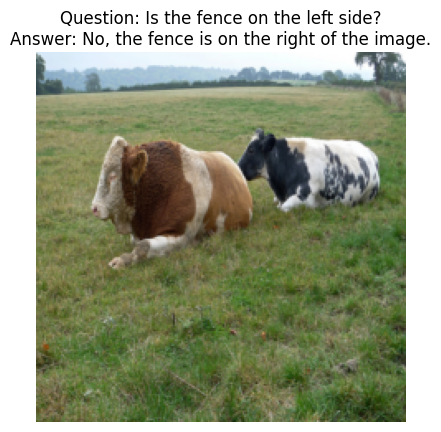

Train Loss: 1.7632, Validation Loss: 3.505, BLEU: 0.162


In [18]:
best_bleu = 0
epochs_since_improvement = 0
num_epochs = 100
patience = 20
    
for epoch in range(num_epochs):
    if epochs_since_improvement == 20:
        break
    if epochs_since_improvement > 0 and epochs_since_improvement % 8 == 0:
        adjust_learning_rate(optimizer, 0.8)

    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss = train(model=model, 
                       dataloader=train_dataloader, 
                       criterion=criterion, 
                       optimizer=optimizer, 
                       device=device,
                       vocab_size=vocab_size)
    
    val_bleu, val_loss = validate(model=model, 
                                  dataloader=val_dataloader, 
                                  tokenizer=tokenizer, 
                                  device=device,
                                  criterion=criterion,
                                  vocab_size=vocab_size)

    print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation BLEU: {val_bleu:.4f}")

    if val_bleu > best_bleu:
        best_bleu = val_bleu
        epochs_since_improvement = 0
        torch.save(model.state_dict(), 'best_vqa_model.pth')
    else:
        epochs_since_improvement += 1

    if epochs_since_improvement >= patience:
        break

In [ ]:
test_dataset = GQADataset(questions_file=test_questions_file, 
                          images_dir=images_dir, 
                          tokenizer=tokenizer, 
                          transform=transform)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=32, 
                             shuffle=False, 
                             num_workers=4)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


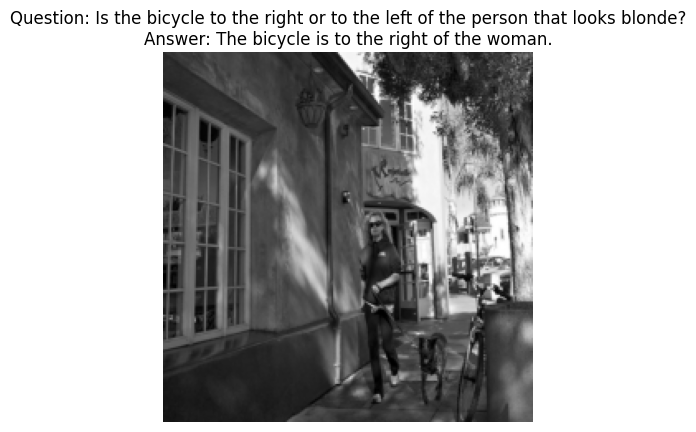

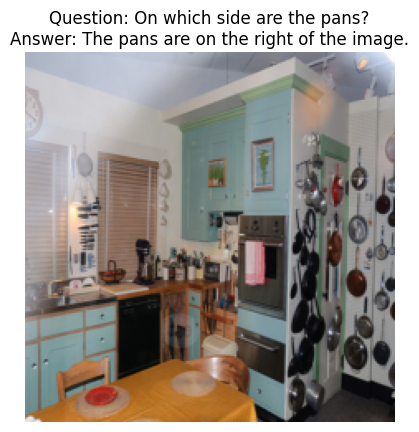

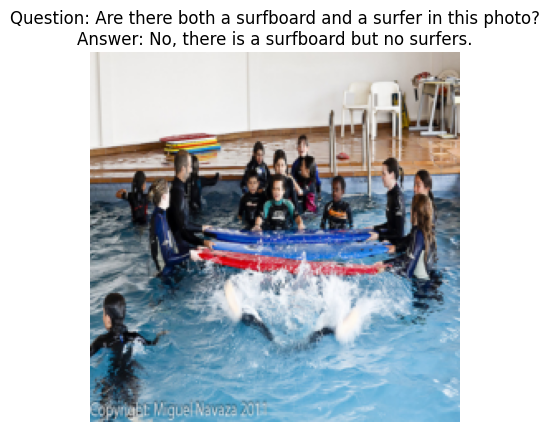

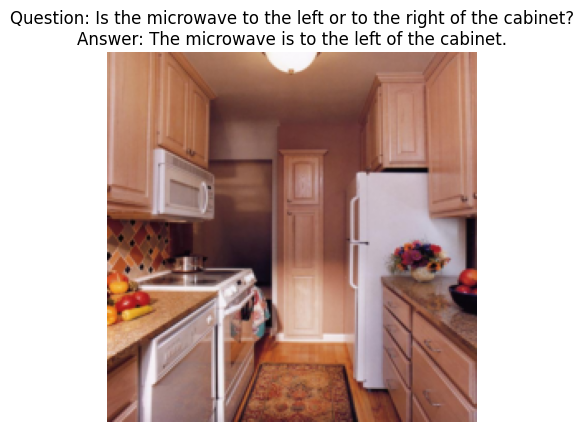

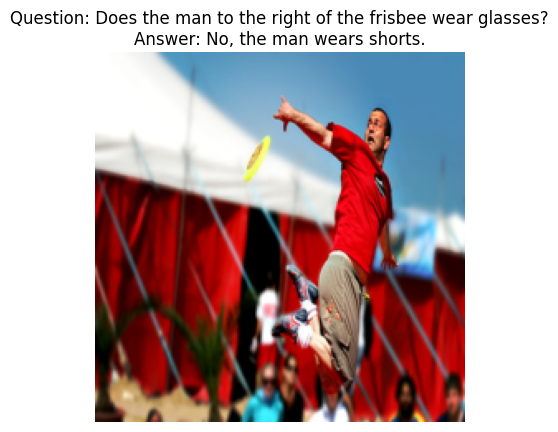

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [20]:
# Print some examples
for i, batch in enumerate(val_dataloader):
    if i >= 5:  # Show 5 examples
        break
    
    image = batch['image'][0]
    question = batch['question'][0]
    pred = model.beam_search_inference(image, question)

    show_image(image, question, pred)